# How do our aggregate models stack up?

In this notebook we examine the aggregate models obtained for galaxy builder galaxies, and compare these morels to various measures of ellipticity present in the NASA-Sloan Atlas, including an r-band single Sérsic compnent fit.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import numpy as np
import pandas as pd
from copy import deepcopy
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import lib.galaxy_utilities as gu
import gzbuilder_analysis.parsing as parsing
import gzbuilder_analysis.aggregation as aggregation
import gzbuilder_analysis.rendering as rendering
import gzbuilder_analysis.fitting as fitting
from gzbuilder_analysis.fitting.jupyter import UpdatableDisplay
from IPython.display import HTML

We can use a precalculated csv file if available, this flag determines whether to recalculate this csv.

In [3]:
SHOULD_RECALCULATE = False
AGG_RESULTS_DF_LOC = 'aggregation_results.pickle'
BEST_MODELS_LOC = 'best-models.pickle'

In [4]:
sid_list = np.loadtxt('lib/subject-id-list.csv', dtype='u8')
simard_df = pd.read_csv('lib/simard-catalog.csv', index_col=0)

Define a function which will obtain the disc axis ratio and sample variance of the cluster used to obtain the aggregate disk:

In [5]:
def get_model(subject_id):
    gal, angle = gu.get_galaxy_and_angle(subject_id)
    diff_data = gu.get_diff_data(subject_id)
    size_diff = diff_data['width'] / diff_data['imageWidth']

    cls = gu.classifications.query(
        'subject_ids == {}'.format(subject_id)
    )

    model, error, masks, arms = aggregation.make_model(
        cls, gal, angle
    )
    scaled_model = parsing.scale_aggregate_model(model, size_diff=size_diff)
    scaled_errors = parsing.scale_model_errors(error, size_diff=size_diff)
    return scaled_model, scaled_errors, masks, arms

In [6]:
if SHOULD_RECALCULATE:
    tqdm.pandas(desc='Running on all', leave=True)
    aggregation_results = pd.Series(
        sid_list, index=sid_list
    ).progress_apply(get_model)
    aggregation_results.to_pickle(AGG_RESULTS_DF_LOC)
else:
    aggregation_results = pd.read_pickle(AGG_RESULTS_DF_LOC)

In [7]:
axRatios = aggregation_results\
    .apply(lambda m: m[0].get('disk'))\
    .dropna()\
    .apply(lambda d: d.get('axRatio'))\
    .rename('GZB_BA')
errors = aggregation_results\
    .apply(lambda m: m[1].get('disk'))\
    .dropna()\
    .apply(lambda d: d.get('axRatio'))\
    .rename('SIGMA_GZB_BA')
gzb_axratio_df = pd.concat((axRatios, errors), axis=1)

Define a function which obtains the keys needed from the NSA catalog for the comparison

In [8]:
def get_nsa_key(key, name='NSA catalog value'):
    axr = []
    for sid in sid_list:
        metadata = gu.meta_map.get(sid, {})
        NSAID = metadata.get('NSA id', False)
        if NSAID is not False:
            galaxy = gu.df_nsa[gu.df_nsa['NSAID'] == int(NSAID)]
            nsa_val = galaxy[key].values[0]
        else:
            nsa_val = np.nan
        axr.append(nsa_val)
    return pd.Series(data=axr, index=sid_list, name=name)

In [9]:
PETRO_BA90 = get_nsa_key('PETRO_BA90', name='PETRO_BA90')
PETRO_BA50 = get_nsa_key('PETRO_BA50', name='PETRO_BA50')
SERSIC_BA = get_nsa_key('SERSIC_BA', name='SERSIC_BA')

In [10]:
ba_df = pd.concat(
    (gzb_axratio_df, PETRO_BA90, PETRO_BA50, SERSIC_BA),
    axis=1
).dropna()
ba_df.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 292 entries, 20901989 to 21686615
Data columns (total 5 columns):
GZB_BA          292 non-null float64
SIGMA_GZB_BA    292 non-null float64
PETRO_BA90      292 non-null float64
PETRO_BA50      292 non-null float64
SERSIC_BA       292 non-null float64
dtypes: float64(5)
memory usage: 13.7 KB


What do the axis ratio distributions look like?

Text(0.5, 0, 'Axis ratio')

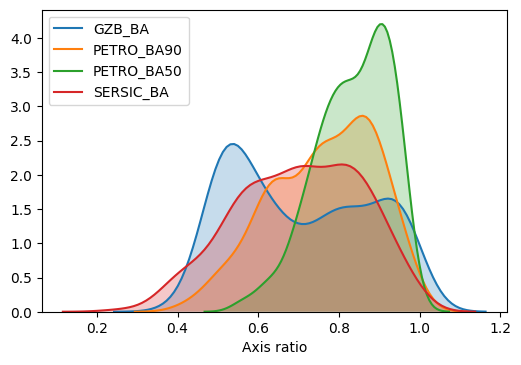

In [11]:
plt.figure(figsize=(6, 4), dpi=100)
for col in ba_df.drop('SIGMA_GZB_BA', axis=1).columns:
    sns.kdeplot(ba_df[col], shade=True)
plt.xlabel('Axis ratio')

We see a distinct peak of Galaxy Builder axis ratios of 0.5, which is the default for the Zooniverse ellipse drawing tool. We need a way of dealing with this.

What is the distribution of our reported errors?

Shapiro-Wilk probability data is Normally distributed: 0.0079


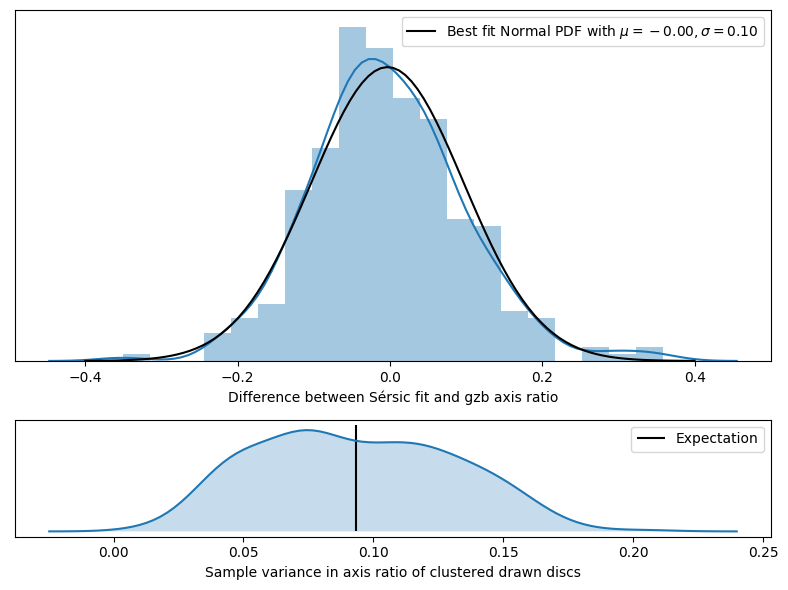

In [12]:
d = ba_df['SERSIC_BA'] - ba_df['GZB_BA']
mu, std = st.norm.fit(d.values.T)
x = np.linspace(-0.4, 0.4, 100)
_, ax = plt.subplots(nrows=2, figsize=(8, 6), dpi=100, gridspec_kw={'height_ratios': (3, 1)})
plt.sca(ax[0])
sns.distplot(d)
plt.plot(x, st.norm.pdf(x, loc=mu, scale=std), 'k', 
         label=r'Best fit Normal PDF with $\mu={:.2f}, \sigma={:.2f}$'.format(mu, std))
plt.xlabel('Difference between Sérsic fit and gzb axis ratio')
plt.legend()
plt.yticks([])
plt.sca(ax[1])
sns.kdeplot(ba_df['SIGMA_GZB_BA'].values.T, shade=True)
plt.xlabel('Sample variance in axis ratio of clustered drawn discs')
plt.vlines(ba_df['SIGMA_GZB_BA'].mean(), 0, max(plt.ylim()), label='Expectation')
plt.legend()
plt.yticks([])
plt.tight_layout()

print('Shapiro-Wilk probability data is Normally distributed: {:.4f}'.format(st.shapiro(d)[1]))

We see that compared to the NSA catalog Sérsic fit, the discrepancy is almost a normal distribution with a standard deviation around 0.1 (a normal distribution fit with varying $\mu$ and $\sigma$ is plotted), which is near the expectation value of the reported error (black line on lower panel).

## NSA catalog comparison plot

Let's compare Galaxy Builder axis ratios to that of an r-band Sersic component fit (from NSA catalog)

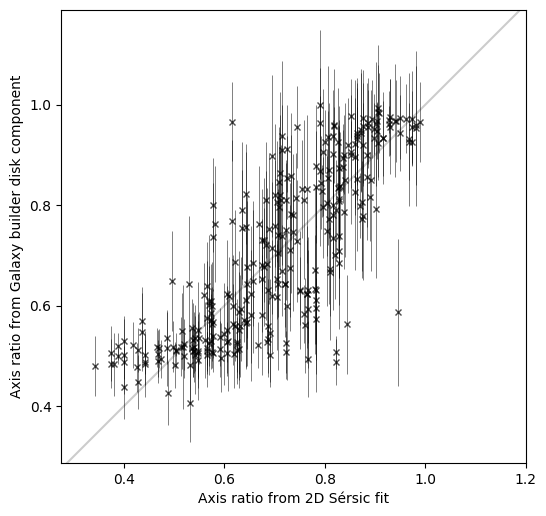

In [13]:
plt.figure(figsize=(6, 6), dpi=100)
plt.errorbar(ba_df['SERSIC_BA'], ba_df['GZB_BA'], fmt='xk',
             yerr=ba_df['SIGMA_GZB_BA'],
             markersize=5, linewidth=0.5, alpha=0.7)
plt.axis('equal')
l = plt.ylim()
line = [0, 1E2]
plt.plot(line, line, 'k', alpha=0.2)
plt.xlim(*l); plt.ylim(*l)
plt.xlabel('Axis ratio from 2D Sérsic fit')
plt.ylabel('Axis ratio from Galaxy builder disk component');

We'll also show this in a perhaps more informative manner: we display the discrepancies between the results and highlight points outside of $1\sigma$ and $1\sigma$ (assuming zero error on the Sérsic fit result).

Black cross: within 1σ
Orange dot:  between 1σ and 2σ (66.10%)
Red star:    outside 2σ (88.36%)


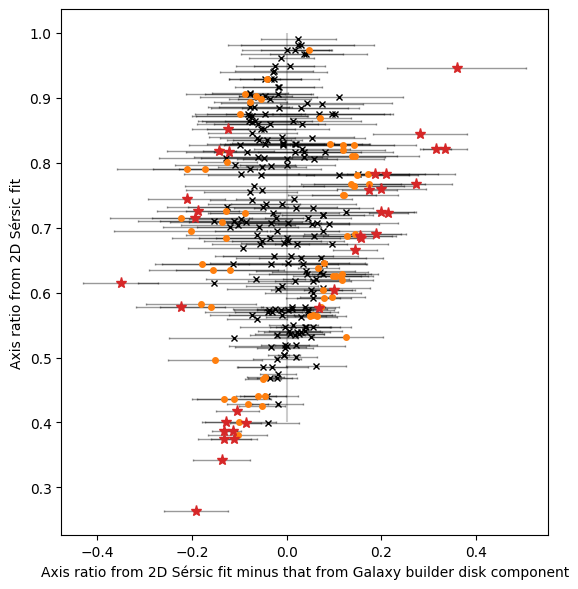

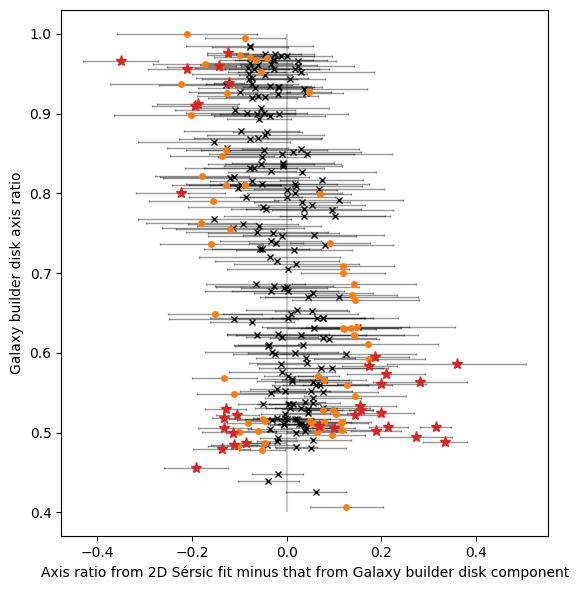

In [14]:
diff = ba_df['SERSIC_BA'] - ba_df['GZB_BA']
# make colors
c = np.zeros(len(diff))
c[diff.abs() > ba_df['SIGMA_GZB_BA']] -= 1
c[diff.abs() > ba_df['SIGMA_GZB_BA'] * 2] -= 1
# plot
o = np.argsort(ba_df['SERSIC_BA'])
c = c[o]

for ytype in ('SERSIC_BA', 'GZB_BA'):
    plt.figure(figsize=(6, 6), dpi=100)
    plt.errorbar(diff.iloc[o], ba_df[ytype].iloc[o],
                 fmt='xk', xerr=ba_df['SIGMA_GZB_BA'].iloc[o],
                 markersize=0, linewidth=1,
                 capsize=1, alpha=0.4)
    plt.xlabel('Axis ratio from 2D Sérsic fit minus that from Galaxy builder disk component')
    plt.ylabel(
        'Axis ratio from 2D Sérsic fit'
        if ytype == 'SERSIC_BA'
        else 'Galaxy builder disk axis ratio'
    )
    plt.vlines(0, 0.4, 1, alpha=0.2)
    cs = ('k', 'C1', 'C3'); ms = (('x', 5), ('o', 4), ('*', 8))
    for i in range(3):
        plt.plot(
            diff.iloc[o][c == -i], ba_df[ytype].iloc[o][c == -i],
            ms[i][0], color=cs[i], markersize=ms[i][1]
        )
    plt.tight_layout()

print('Black cross: within 1σ')
print('Orange dot:  between 1σ and 2σ ({:.2%})'.format(sum(c == 0) / len(c)))
print('Red star:    outside 2σ ({:.2%})'.format(sum(c != -2) / len(c)))

It is obvious that the presence in a cluster of disks with the default axis ratio is causing issues with the models, this is something that can hopefully be adressed with a few iterations of least squares fitting.

## Best individual classification

What about the best individual classification? We have no real uncertainty on this measure, but can examine the distribution.

In [15]:
def loss(rendered_model, galaxy_data, pixel_mask=None):
    if pixel_mask is None:
        pixel_mask = np.ones_like(rendered_model)
    Y = rendered_model * pixel_mask
    return mean_squared_error(
        (rendered_model * pixel_mask).ravel(),
        0.8 * (galaxy_data * pixel_mask).ravel()
    )

def get_best_model(subject_id):
    gal, angle = gu.get_galaxy_and_angle(subject_id)
    ba = gal['PETRO_BA90']
    im = gu.get_image(subject_id)
    psf = gu.get_psf(subject_id)
    diff_data = gu.get_diff_data(subject_id)
    pixel_mask = 1 - np.array(diff_data['mask'])[::-1]
    galaxy_data = np.array(diff_data['imageData'])[::-1]
    size_diff = diff_data['width'] / diff_data['imageWidth']

    query_string = 'subject_ids == {}'.format(subject_id)
    cls = gu.classifications.query(query_string)
    annotations = cls['annotations'].apply(json.loads)

    models = annotations.apply(parsing.parse_annotation, size_diff=size_diff)
    rendered = models.apply(
        rendering.calculate_model,
        image_size=diff_data['imageData'].shape[0],
        psf=psf
    )
    diffs = rendered.apply(
        rendering.compare_to_galaxy, args=(galaxy_data,),
        pixel_mask=pixel_mask, stretch=False
    )
    losses = rendered.apply(loss, args=(galaxy_data,), pixel_mask=pixel_mask)
    return losses.idxmin(), models.loc[losses.idxmin()]

In [16]:
if SHOULD_RECALCULATE:
    tqdm.pandas(desc='Running on all', leave=True)
    best_models = pd.Series(sid_list, index=sid_list)\
        .progress_apply(get_best_model)
    best_models.to_pickle(BEST_MODELS_LOC)
else:
    best_models = pd.read_pickle(BEST_MODELS_LOC)

In [17]:
disks = best_models.apply(lambda m: m.get('disk')).dropna()
df_all = pd.concat((ba_df, disks.apply(lambda d: d.get('axRatio')).rename('BA_BEST_INDIV')), axis=1).dropna()

Text(0.5, 0, 'Axis ratio')

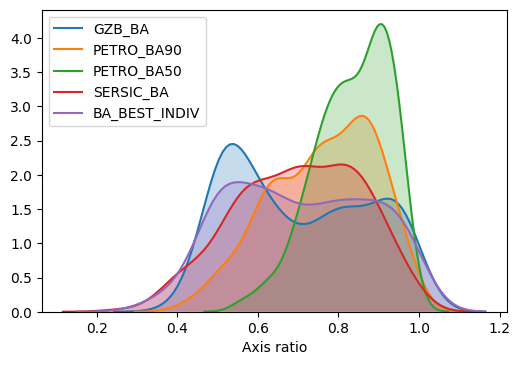

In [18]:
plt.figure(figsize=(6, 4), dpi=100)
for col in df_all.drop('SIGMA_GZB_BA', axis=1).columns:
    sns.kdeplot(df_all[col], shade=True)
plt.xlabel('Axis ratio')

We see a similar error to that for the aggregate result:

Shapiro-Wilk probability data is Normally distributed: 0.0036


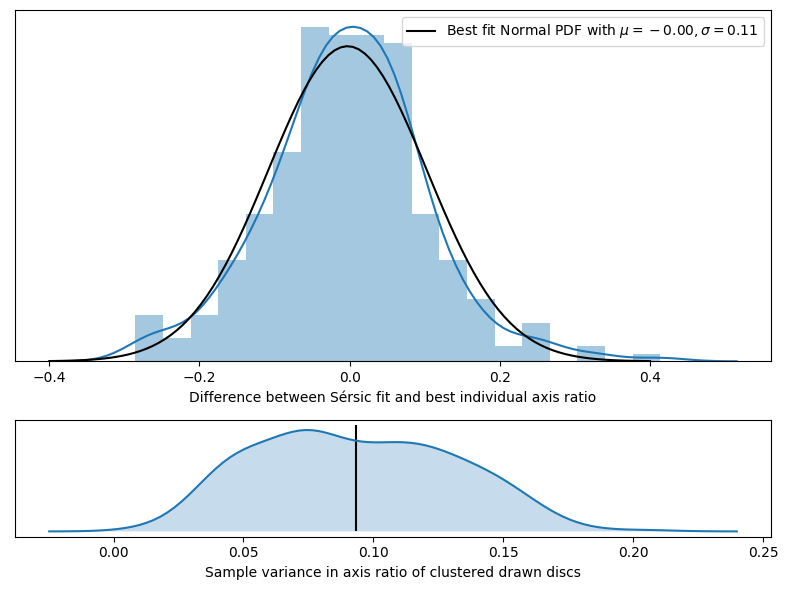

In [19]:
d = df_all['SERSIC_BA'] - df_all['BA_BEST_INDIV']
mu, std = st.norm.fit(d.values.T)
x = np.linspace(-0.4, 0.4, 100)
_, ax = plt.subplots(nrows=2, figsize=(8, 6), dpi=100, gridspec_kw={'height_ratios': (3, 1)})
plt.sca(ax[0])
sns.distplot(d)
plt.plot(x, st.norm.pdf(x, loc=mu, scale=std), 'k', 
         label=r'Best fit Normal PDF with $\mu={:.2f}, \sigma={:.2f}$'.format(mu, std))
plt.xlabel('Difference between Sérsic fit and best individual axis ratio')
plt.legend()
plt.yticks([])
plt.sca(ax[1])
sns.kdeplot(ba_df['SIGMA_GZB_BA'].values.T, shade=True)
plt.xlabel('Sample variance in axis ratio of clustered drawn discs')
plt.vlines(ba_df['SIGMA_GZB_BA'].mean(), 0, max(plt.ylim()), label='Expectation')
plt.yticks([])
plt.tight_layout()

print('Shapiro-Wilk probability data is Normally distributed: {:.4f}'.format(st.shapiro(d)[1]))

Interestingly, there is a very similar delta between the aggregate axis ratio and the best individual (**Q: is that to be expected if things are drawn from the same underlying distribution?**)

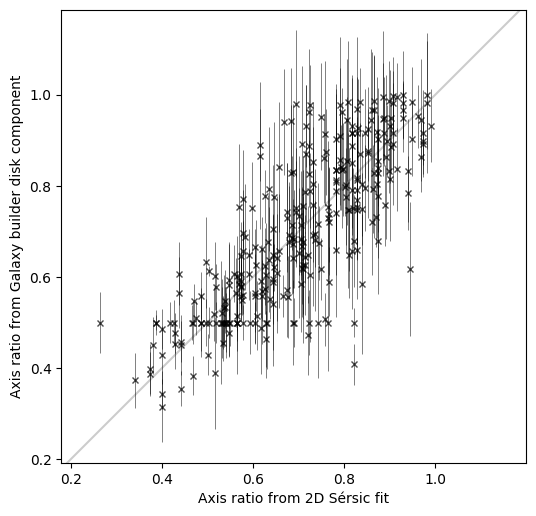

In [20]:
plt.figure(figsize=(6, 6), dpi=100)
plt.errorbar(df_all['SERSIC_BA'], df_all['BA_BEST_INDIV'], fmt='xk',
             yerr=df_all['SIGMA_GZB_BA'],
             markersize=5, linewidth=0.5, alpha=0.7)
plt.axis('equal')
l = plt.ylim()
line = [0, 1E2]
plt.plot(line, line, 'k', alpha=0.2)
plt.xlim(*l); plt.ylim(*l)
plt.xlabel('Axis ratio from 2D Sérsic fit')
plt.ylabel('Axis ratio from Galaxy builder disk component');

Black cross: within 1σ
Orange dot:  between 1σ and 2σ (63.36%)
Red star:    outside 2σ (88.36%)


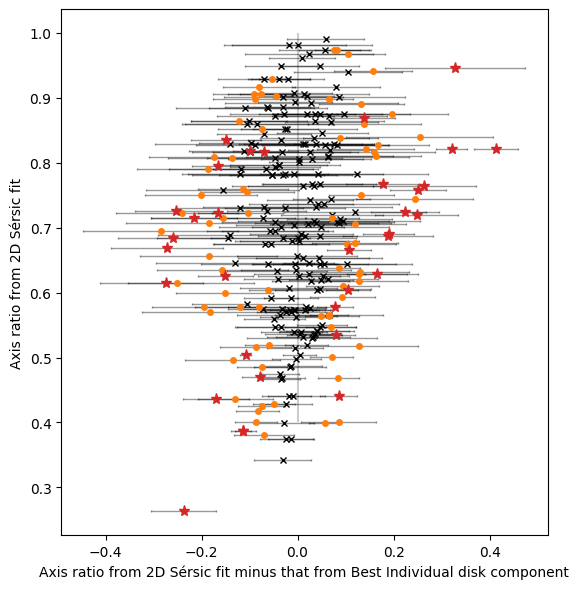

In [21]:
diff2 = df_all['SERSIC_BA'] - df_all['BA_BEST_INDIV']
# make colors
c2 = np.zeros(len(diff))
c2[diff2.abs() > df_all['SIGMA_GZB_BA']] -= 1
c2[diff2.abs() > df_all['SIGMA_GZB_BA'] * 2] -= 1
# plot
o2 = np.argsort(df_all['SERSIC_BA'])
c2 = c2[o2]
plt.figure(figsize=(6, 6), dpi=100)
plt.errorbar(diff2.iloc[o2], df_all['SERSIC_BA'].iloc[o2],
             fmt='xk', xerr=df_all['SIGMA_GZB_BA'].iloc[o2],
             markersize=0, linewidth=1,
             capsize=1, alpha=0.4)
plt.xlabel('Axis ratio from 2D Sérsic fit minus that from Best Individual disk component')
plt.ylabel('Axis ratio from 2D Sérsic fit')
plt.vlines(0, 0.4, 1, alpha=0.2)
for i in range(3):
    plt.plot(
        diff2.iloc[o2][c2 == -i], df_all['SERSIC_BA'].iloc[o2][c2 == -i],
        ms[i][0], color=cs[i], markersize=ms[i][1]
    )
plt.tight_layout()

print('Black cross: within 1σ')
print('Orange dot:  between 1σ and 2σ ({:.2%})'.format(sum(c2 == 0) / len(c2)))
print('Red star:    outside 2σ ({:.2%})'.format(sum(c2 != -2) / len(c2)))

## Optimized best individual classification

We obviously have a problem with people leaving things at the default value. We'll fit just the disk axis ratio and see if that has an impact on the distribution

In [22]:
from gzbuilder_analysis.fitting import Model, fit

In [23]:
def make_model_fitter(subject_id, m):
    psf = gu.get_psf(subject_id)
    diff_data = gu.get_diff_data(subject_id)
    pixel_mask = 1 - np.array(diff_data['mask'])[::-1]
    galaxy_data = np.array(diff_data['imageData'])[::-1]
    return fitting.Model(m, galaxy_data, psf=psf, pixel_mask=pixel_mask)

In [24]:
models = pd.Series([]).rename('Models')
with tqdm(best_models.items(), total=len(best_models)) as bar:
  for i, model in bar:
      models[i] = make_model_fitter(i, model)

100%|██████████| 296/296 [01:28<00:00,  5.45it/s]


In [40]:
optimized_models = pd.Series([])

In [41]:
display(HTML('<br>Fitting models</br>'))
tpl = [('disk', 'axRatio')]
v = lambda *a: HTML('{} / {}: {}'.format(*a))
d = UpdatableDisplay(v(0, len(sid_list), ''))
for i, (s, model) in enumerate(models.items()):
    if s in optimized_models.index:
        continue
    d(v(i, len(sid_list), s))
    try:
        new_model, res = fit(model, progress=True, template=tpl)
        if res['success']:
            optimized_models[s] = new_model
    except ZeroDivisionError:
        pass
d(v(i+1, len(sid_list), 'All done'))

In [42]:
axRatios = optimized_models\
    .apply(lambda m: m['disk']['axRatio'] if m['disk'] is not None else np.nan)\
    .rename('BA_FIT')

df_fit = pd.concat((df_all, axRatios.rename('BA_FIT')), axis=1).dropna()

simard_comparison = pd.concat((
    df_fit,
    simard_df['i'].apply(lambda i: np.arctan(np.deg2rad(90 - i))).rename('SIMARD_BA')
), axis=1).dropna()

What is the effect on the axis ratios of this optimization?

Text(0.5, 1.0, 'Optimized')

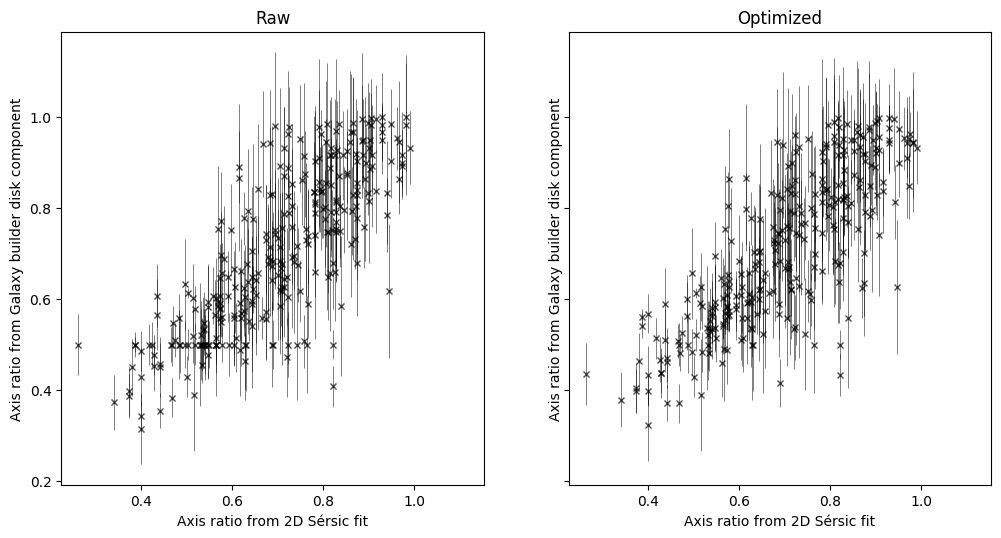

In [43]:
f, ax = plt.subplots(ncols=2, sharey=True, figsize=(12, 6), dpi=100)
plt.sca(ax[0])
plt.errorbar(df_all['SERSIC_BA'], df_all['BA_BEST_INDIV'], fmt='xk',
             yerr=df_all['SIGMA_GZB_BA'],
             markersize=5, linewidth=0.5, alpha=0.7)
plt.axis('equal')
l = plt.ylim()
line = [0, 1E2]
# plt.plot(line, line, 'k', alpha=0.2)
plt.xlim(*l); plt.ylim(*l)
plt.xlabel('Axis ratio from 2D Sérsic fit')
plt.ylabel('Axis ratio from Galaxy builder disk component');
plt.title('Raw')
plt.sca(ax[1])
plt.errorbar(df_fit['SERSIC_BA'], df_fit['BA_FIT'], fmt='xk',
             yerr=df_fit['SIGMA_GZB_BA'],
             markersize=5, linewidth=0.5, alpha=0.7)
plt.axis('equal')
l = plt.ylim()
line = [0, 1E2]
# plt.plot(line, line, 'k', alpha=0.2)
plt.xlim(*l); plt.ylim(*l)
plt.xlabel('Axis ratio from 2D Sérsic fit')
plt.ylabel('Axis ratio from Galaxy builder disk component');
plt.title('Optimized')

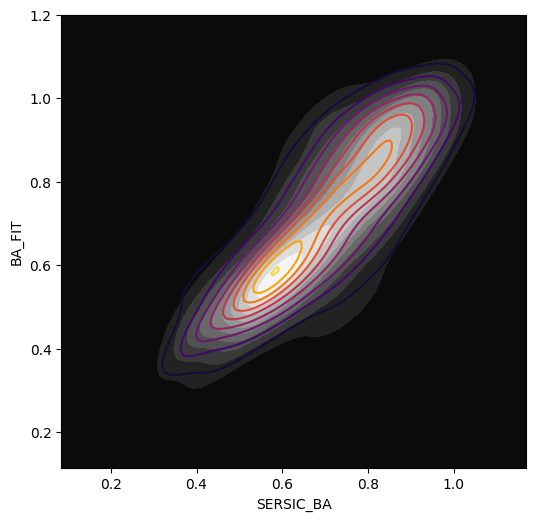

In [71]:
plt.figure(figsize=(6, 6), dpi=100)
sns.kdeplot(df_fit['SERSIC_BA'], df_fit['BA_BEST_INDIV'], cmap="gray", shade=True)
sns.kdeplot(df_fit['SERSIC_BA'], df_fit['BA_FIT'], cmap="inferno", shade=False, shade_lowest=False)

We see that thel line at 0.5 has gone, but the scatter hasn't improved much.

Let's have a look at the differences between our three measures of Galaxy builder axis ratio, and some results in the literature:


Comparing to NSA Sersic fit:
Aggregate = N(μ=-0.0032, σ=0.1000), Shapiro-Wilk test: 0.0079
Best Individual = N(μ=-0.0028, σ=0.1056), Shapiro-Wilk test: 0.0036
Optimized best individual = N(μ=-0.0129, σ=0.1041), Shapiro-Wilk test: 0.0006

Comparing to Simard catalogue:
Aggregate = N(μ=-0.0447, σ=0.1040), Shapiro-Wilk test: 0.0025
Best Individual = N(μ=-0.0443, σ=0.1129), Shapiro-Wilk test: 0.0004
Optimized best individual = N(μ=-0.0544, σ=0.1160), Shapiro-Wilk test: 0.0015


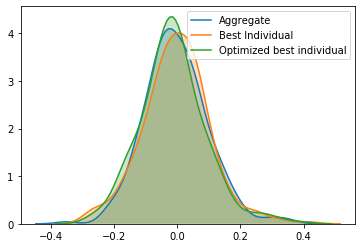

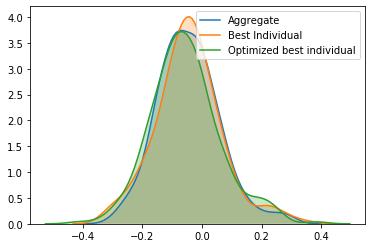

In [44]:
names = ('Aggregate', 'Best Individual', 'Optimized best individual')

d_agg = simard_comparison['SERSIC_BA'] - simard_comparison['GZB_BA']
d_bI = simard_comparison['SERSIC_BA'] - simard_comparison['BA_BEST_INDIV']
d_obI = simard_comparison['SERSIC_BA'] - simard_comparison['BA_FIT']

d_agg2 = simard_comparison['SIMARD_BA'] - simard_comparison['GZB_BA']
d_bI2 = simard_comparison['SIMARD_BA'] - simard_comparison['BA_BEST_INDIV']
d_obI2 = simard_comparison['SIMARD_BA'] - simard_comparison['BA_FIT']

print('\nComparing to NSA Sersic fit:')
for name, d in zip(names, (d_agg, d_bI, d_obI)):
  mu, sigma = st.norm.fit(d)
  sns.kdeplot(d, shade=True, label=name)
  res = st.shapiro(d)
  print('{} = N(μ={:.4f}, σ={:.4f}), Shapiro-Wilk test: {:.4f}'.format(name, mu, sigma, res[1]))
plt.legend();

plt.figure()
print('\nComparing to Simard catalogue:')
for name, d in zip(names, (d_agg2, d_bI2, d_obI2)):
  mu, sigma = st.norm.fit(d)
  res = st.shapiro(d)
  sns.kdeplot(d, shade=True, label=name)
  print('{} = N(μ={:.4f}, σ={:.4f}), Shapiro-Wilk test: {:.4f}'.format(name, mu, sigma, res[1]))
plt.legend();

We see from the Shapiro-Wilk tests that the differences between our results and the existing fits are not Normally distributed (less than 1% level that they are), so a normal fit is a bit disingenuous... HOWEVER, the kde plots (and normal fit) indicate that we are generally within our expected uncertainty.

In [45]:
simard_comparison = pd.concat((
    df_fit,
    simard_df['i'].apply(lambda i: np.arctan(np.deg2rad(90 - i))).rename('SIMARD_BA')
), axis=1)
simard_comparison[['SERSIC_BA', 'SIMARD_BA', 'GZB_BA', 'BA_BEST_INDIV', 'BA_FIT']].dropna().corr()

,SERSIC_BA,SIMARD_BA,GZB_BA,BA_BEST_INDIV,BA_FIT
SERSIC_BA,1.000000,0.875946,0.812727,0.794880,0.795369
SIMARD_BA,0.875946,1.000000,0.800717,0.768754,0.749921
GZB_BA,0.812727,0.800717,1.000000,0.823144,0.798885
BA_BEST_INDIV,0.794880,0.768754,0.823144,1.000000,0.938239
BA_FIT,0.795369,0.749921,0.798885,0.938239,1.000000


Text(0.5, 0, 'Axis ratio')

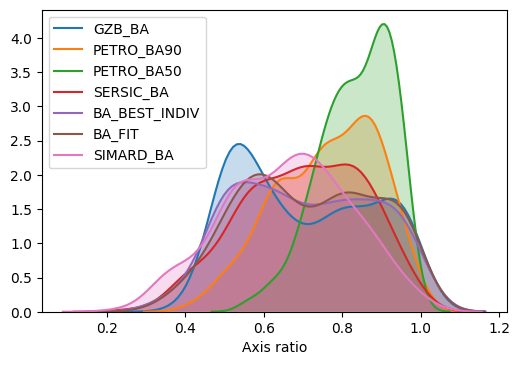

In [53]:
plt.figure(figsize=(6, 4), dpi=100)
for col in simard_comparison.drop('SIGMA_GZB_BA', axis=1).columns:
    sns.kdeplot(simard_comparison.dropna()[col], shade=True)
plt.xlabel('Axis ratio')